In [1]:
# imports

# With the exception of the librosa library installed above, all of these modules are 
# either included in the code base or provided by default on Amazon Sagemaker. 

import glob
import pprint
from multiprocessing import Pool
import multiprocessing as mp
import gc
import pickle
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import soundfile as sf
import pandas as pd

In [2]:
from tensorflow import keras

In [3]:
from db import NABat_DB
import db_handler
from spectrogram import Spectrogram
import dataset_generator as ds
import nabat_detector as nd

In [4]:
# Point to a directory containing .wav files organized by species code. 
directory = '../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002'

In [6]:
# db_handler.delete_pulses_from_db(db_name="db1")
# db_handler.delete_files_from_db(db_name="db1")
# db_handler.delete_predictions_from_db(db_name="db1")

In [7]:
# db_handler.generate_pulses_from_dir(directory)
# Use as many threads as we can, leaving one available to keep notebook responsive.
thread_count = (mp.cpu_count() - 1)
print('using {} threads'.format(thread_count))

# Gather wav files.
files = glob.glob('{}/*.WAV'.format(directory), recursive=True)
progress = np.ceil(len(files) * 0.01).astype('int')
print(progress, files)

# Start the creation process in parallel and report progress.
for i, file in enumerate(files):
    db_handler.process_input_file(file, db_name="db1")
    gc.collect()
    print('{}%'.format(int(i/progress)))

using 7 threads
1 ['../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV']
0%


In [5]:
db = NABat_DB(p="db1")
# Get available information for species.
species = db.query('select * from species;')
sample_classes = ds.get_sample_classes('../Downloads/data/wav')

In [6]:
# Return a list of files belonging to a dataset. 'train', 'test', or 'validate'.
def get_files(draw):
    result = db.query('select id, name, grts_id from file where draw = ? and grts_id != 0 order by id',(draw,))
    return result

# Return list of bat pulses that originated from a given recording file, by file id.
def get_pulses(file_id):
    result =  db.query('select * from pulse where file_id = ? order by id',(file_id,))
    return result

def prediction_set_generator(draw):
    try:
        draw = draw.decode("utf-8")
    except:
        pass
    files = get_files(draw)
    for f in files:
        metadata = get_pulses(f.id)
        for i, m in enumerate(metadata):
            image = Image.open(m.path)
            img = np.array(image)
            img = img[..., :3].astype('float32')
            img /= 255.0
            image.close()
            yield {"input_1": img}, m.id

def insert(data):
    db.conn.executemany(
        "insert into prediction (model_name, pulse_id, confidence, species_id) values (?,?,?,?);", data)
    db.conn.execute('commit;')

# Given a species code, return a numeric id.
def get_manual_id(species_code, species):
    for s in species:
        if s.species_code == species_code:
            return s.id

In [10]:
# Load the tuned model from disk.
m = 1
model = keras.models.load_model(f'models/m-{m}')

# Provide a prediction for each pulse in the test set.
to_predict1 = []
ids = []
data = []
count = 0

for p in prediction_set_generator('train'):     
    count += 1
    to_predict1.append(p[0]['input_1'])
    ids.append(p[1])
    
    # Batch the predictions into groupes of 1024.
    if count != 0 and (count % 1024 == 0 ):
        predictions = model.predict(np.array(to_predict1), batch_size=1024)
        for x, prediction in enumerate(predictions):
            for i, c in enumerate(prediction):
            # max_confidence_index = np.argmax(prediction)
                data.append((str(m), ids[x], float(c), get_manual_id(sample_classes[i], species)))
        
        insert(data)
        to_predict1 = []
        data = []
        ids = []
        
        # Clean up
        gc.collect()
        
        # Report progress.
        print('{}'.format(int(count)))

# Predict the remaining < 1024 predictions not batched in prior step.
predictions = model.predict(np.array(to_predict1),batch_size=len(ids))
for x, prediction in enumerate(predictions):
    for i, c in enumerate(prediction):
    # max_confidence_index = np.argmax(prediction)
        data.append((str(m), ids[x], float(c), get_manual_id(sample_classes[i], species)))
insert(data)
db.conn.close()

2023-08-10 23:15:59.902931: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 9s 9s/step
1024
1/1 [==============================] - 8s 8s/step
2048
1/1 [==============================] - 5s 5s/step


In [7]:
windows = pd.DataFrame(columns=["start_time", "end_time", "low_freq", "high_freq"])

# Loop over file and create sampling windows.
for i in range(50, 1795000, int(50 * (1 - 0.4))):
    start = (i - 50) # where to start in seconds
    end = i  # where to end in seconds
    windows.loc[len(windows.index)] = [start, end, 5000, 100000]

In [8]:
windows

,start_time,end_time,low_freq,high_freq
0,0,50,5000,100000
1,30,80,5000,100000
2,60,110,5000,100000
3,90,140,5000,100000
4,120,170,5000,100000
...,...,...,...,...
59827,1794810,1794860,5000,100000
59828,1794840,1794890,5000,100000
59829,1794870,1794920,5000,100000
59830,1794900,1794950,5000,100000


In [9]:
files = glob.glob('{}/*.WAV'.format(directory), recursive=True)
file = files[0]
# Process file and return pulse metadata.
spectrogram = Spectrogram(sn_thresh=0, amp_thresh=0)
d = spectrogram.process_file(file)

In [10]:
pulses_from_processfile = pd.DataFrame(columns=['Pulse offset', "Pulse peak frequency", "Pulse peak amplitude", "Pulse peak time", "SNR", "Pulse window"])

In [11]:
for m in d.metadata:
    pulses_from_processfile.loc[len(pulses_from_processfile.index)] = m

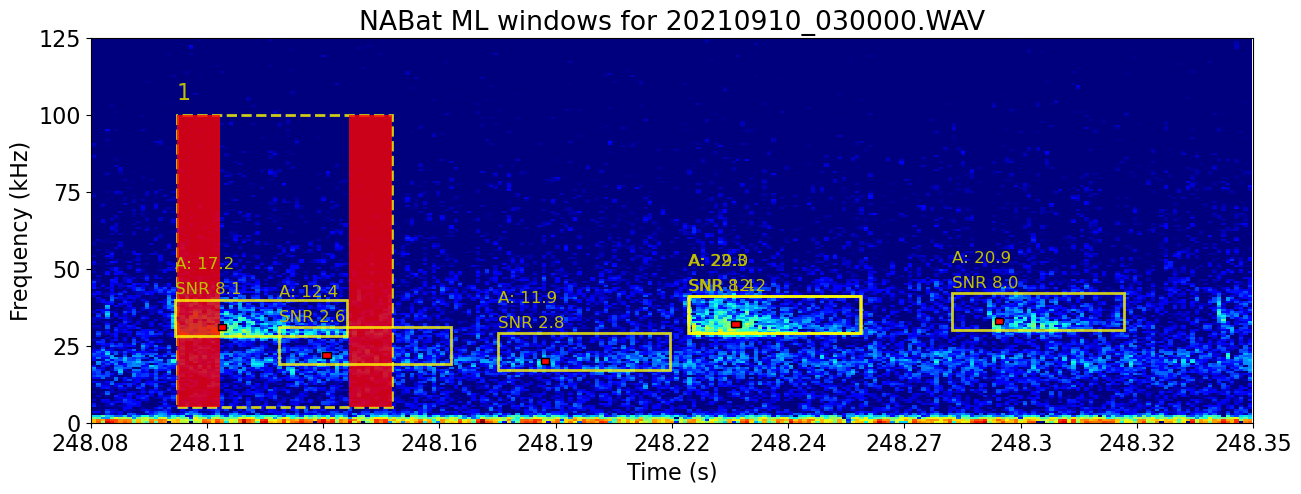

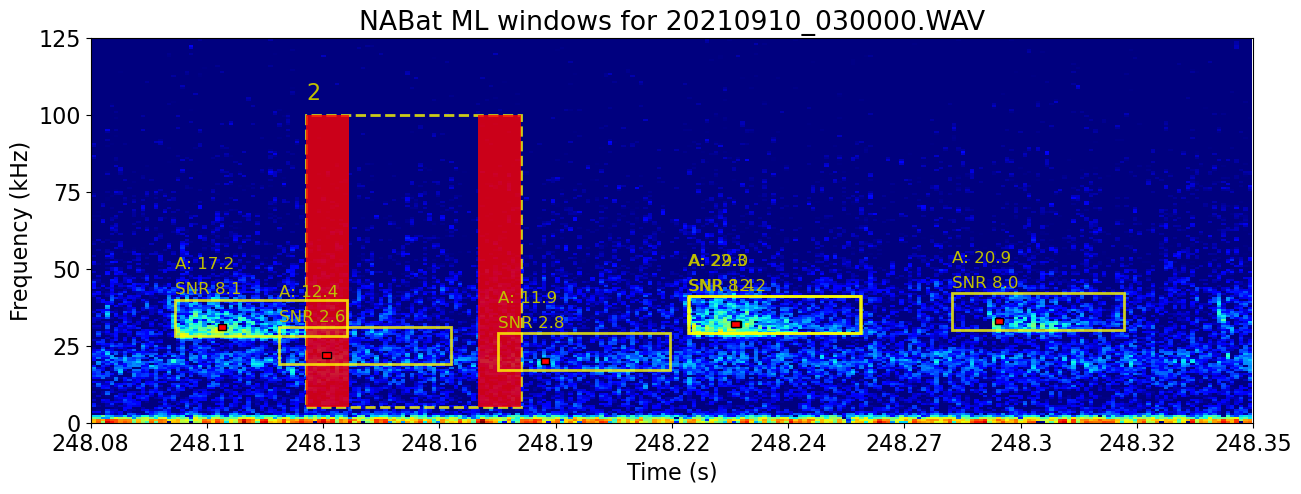

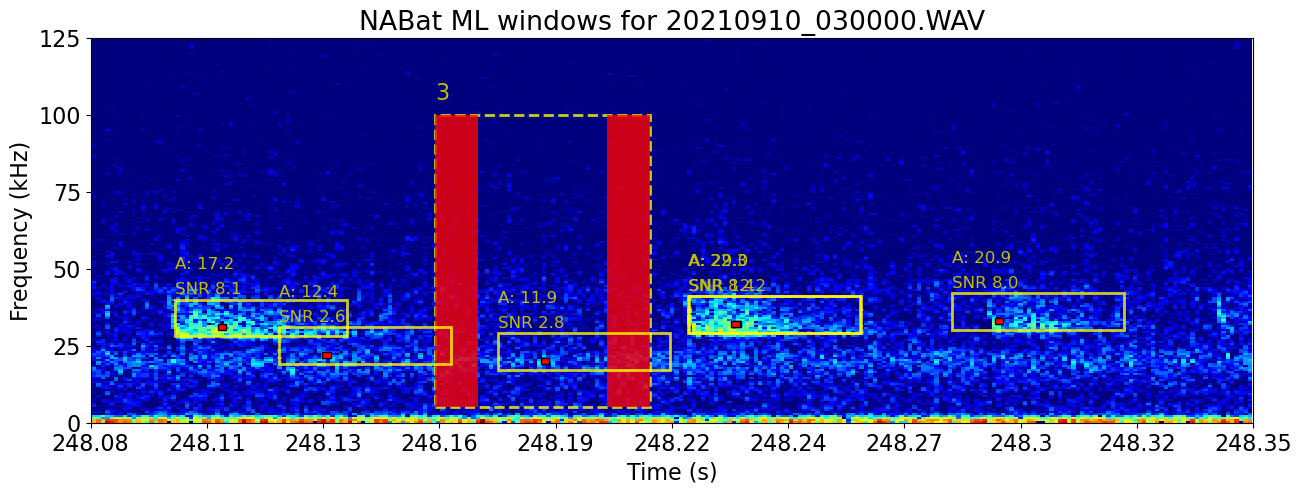

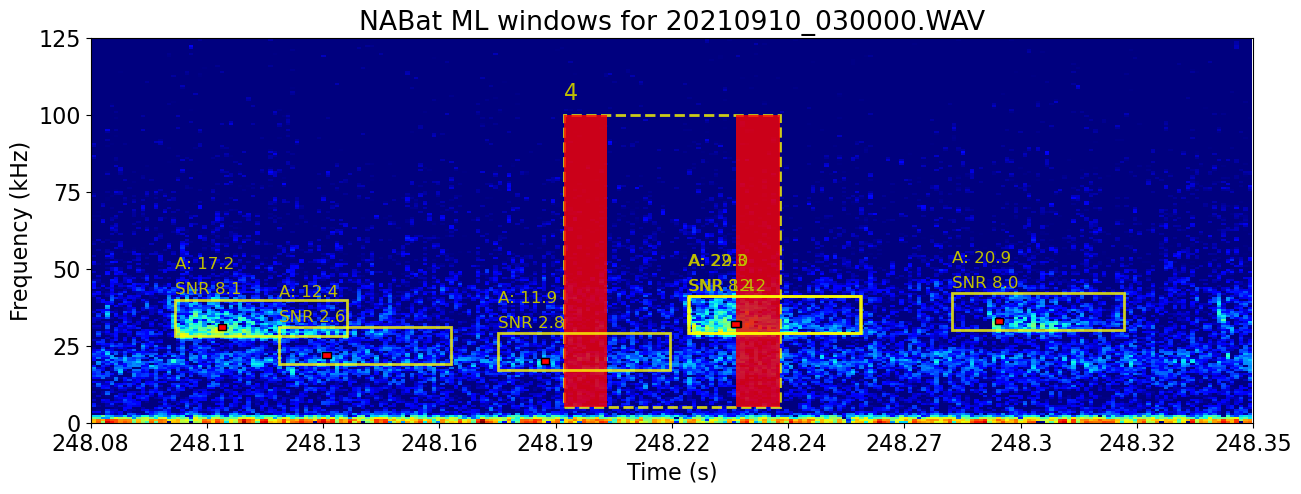

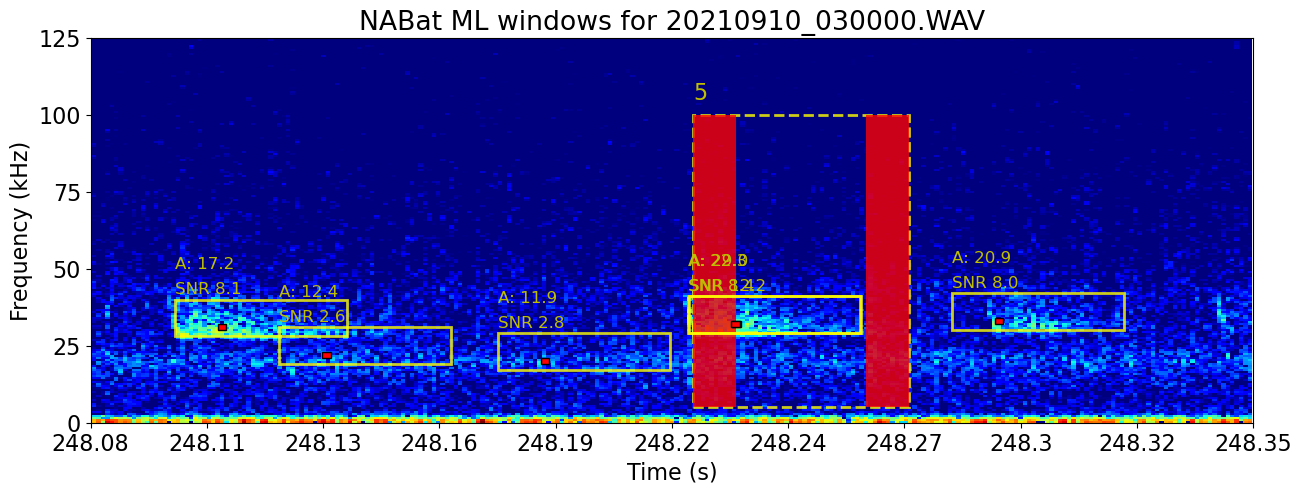

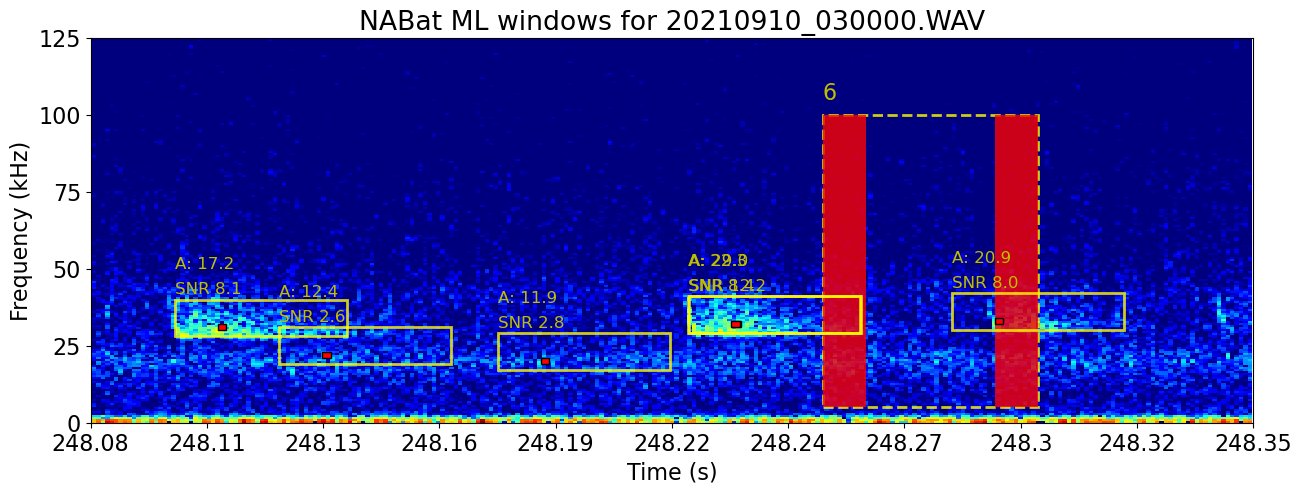

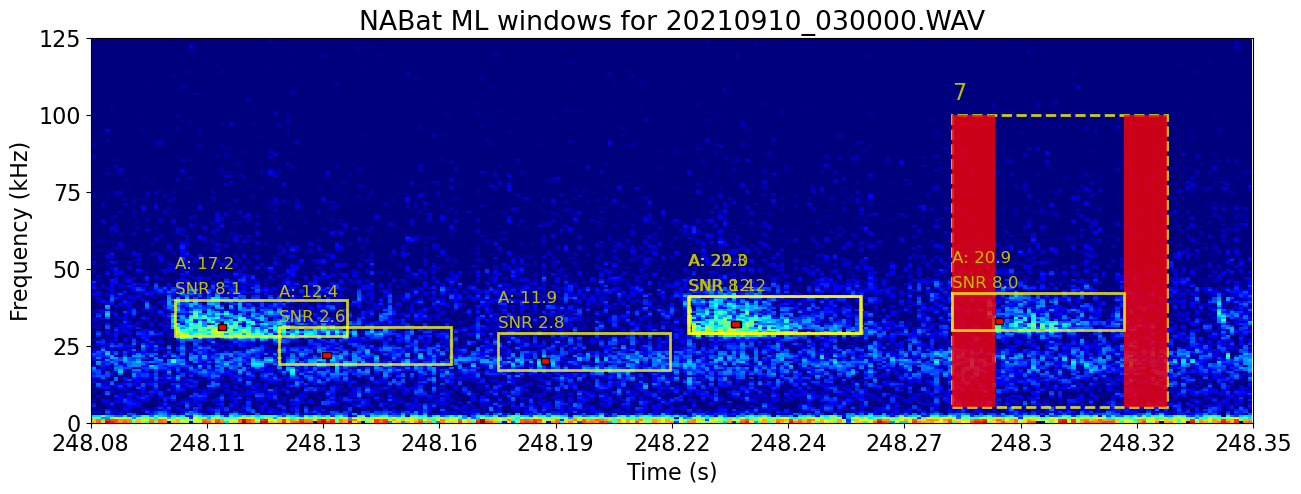

In [12]:
input_files = glob.glob('{}/*.WAV'.format(directory), recursive=True)
audio_file = sf.SoundFile(input_files[0])
fs = audio_file.samplerate
start = 248.08
duration = 0.27
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 30 # hide anything below -rm_dB dB
nabat_ml_predictions = pulses_from_processfile
plot_nbdets = nabat_ml_predictions.loc[np.logical_and(nabat_ml_predictions['Pulse offset']-50 > start*1000, nabat_ml_predictions['Pulse offset']+50 < (start+duration)*1000)]
plot_dets = windows.loc[np.logical_and(windows['start_time'] > 1000*start, windows['end_time'] < 1000*(start+duration))]
count=0
for i, row in plot_dets.iterrows():
    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 16})
    plt.title("NABat ML windows for 20210910_030000.WAV")
    plt.specgram(audio_seg, NFFT=384, cmap='jet', vmin=vmin)

    ax = plt.gca()
    count+=1
    window_length = 50
    plt.text(x=((row['start_time']/1000) - start)*fs/2, y=105000/(fs/2), s=count, color='y')
    rect = patches.Rectangle((((row['start_time']/1000) - start)*fs/2, 5000/(fs/2)), 
                    (window_length/1000)*fs/2, 95000/(fs/2), linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8,
                    linestyle='dashed')
    ax.add_patch(rect)
    rect = patches.Rectangle((((row['start_time']/1000) - start)*fs/2, 5000/(fs/2)), 
                    (0.2*window_length/1000)*fs/2, 95000/(fs/2), linewidth=2, edgecolor='none', facecolor='red', alpha=0.8,
                    linestyle='solid')
    ax.add_patch(rect)
    rect = patches.Rectangle(((((row['end_time'] - 0.2*window_length)/1000) - start)*fs/2, 5000/(fs/2)), 
                    (0.2*window_length/1000)*fs/2, 95000/(fs/2), linewidth=2, edgecolor='none', facecolor='red', alpha=0.8,
                    linestyle='solid')
    ax.add_patch(rect)


    for index, row in plot_nbdets.iterrows():
        plt.text(x=(((row['Pulse offset'] -50 + row['Pulse peak time'])/1000) - start - 0.01)*fs/2, y=(row['Pulse peak frequency']+12000)/(fs/2), 
                            s=f'SNR {round(row["SNR"], 1)}', color='y', fontsize=12)
        plt.text(x=(((row['Pulse offset'] -50 + row['Pulse peak time'])/1000) - start - 0.01)*fs/2, y=(row['Pulse peak frequency']+20000)/(fs/2), 
                            s=f'A: {round(row["Pulse peak amplitude"], 1)}', color='y', fontsize=12)
        rect = patches.Rectangle((((row['Pulse offset'] -50 + row['Pulse peak time'])/1000 - start - 0.01)*(fs/2), (row['Pulse peak frequency']-2000)/(fs/2)), 
                        0.04*(fs/2), 12000/(fs/2), linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)
        rect = patches.Rectangle((((row['Pulse offset']-50 + row['Pulse peak time'])/1000 - start)*(fs/2), row['Pulse peak frequency']/(fs/2)), 
                        0.002*(fs/2), 2000/(fs/2), linewidth=1, edgecolor='k', facecolor='red')
        ax.add_patch(rect)


    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
plt.show()

In [13]:
with open('models/training_history_{}.p'.format(0), 'rb') as fp:
    test = pickle.load(fp)[0]
    print(test)

{'loss': [0.5298142433166504, 0.4064020812511444, 0.7570512294769287, 2.4406888484954834, 3.4314444065093994, 3.3699564933776855, 3.306544065475464, 3.2827937602996826, 3.2675132751464844, 3.257652997970581, 3.2514781951904297, 3.2474892139434814, 3.2448158264160156, 3.24306058883667, 3.241912603378296, 3.2411773204803467, 3.2407217025756836, 3.2404472827911377, 3.2402071952819824, 3.2393956184387207], 'accuracy': [0.9190636873245239, 0.9057503342628479, 0.8020178079605103, 0.2575700879096985, 0.020736631006002426, 0.012224618345499039, 0.0, 0.0, 0.0020615030080080032, 0.013370320200920105, 0.02230793423950672, 0.028995944187045097, 0.034407150000333786, 0.03866315633058548, 0.042067963629961014, 0.04480396583676338, 0.046992771327495575, 0.04875597357749939, 0.05021517351269722, 0.05240397900342941], 'val_loss': [16.747495651245117, 10.094766616821289, 8.86790943145752, 3.3888602256774902, 3.2550861835479736, 3.2302792072296143, 3.2034687995910645, 3.186532974243164, 3.175930976867676

models/training_history_0.p
Training Accuracy 0 try?
Training Accuracy 0
models/training_history_1.p


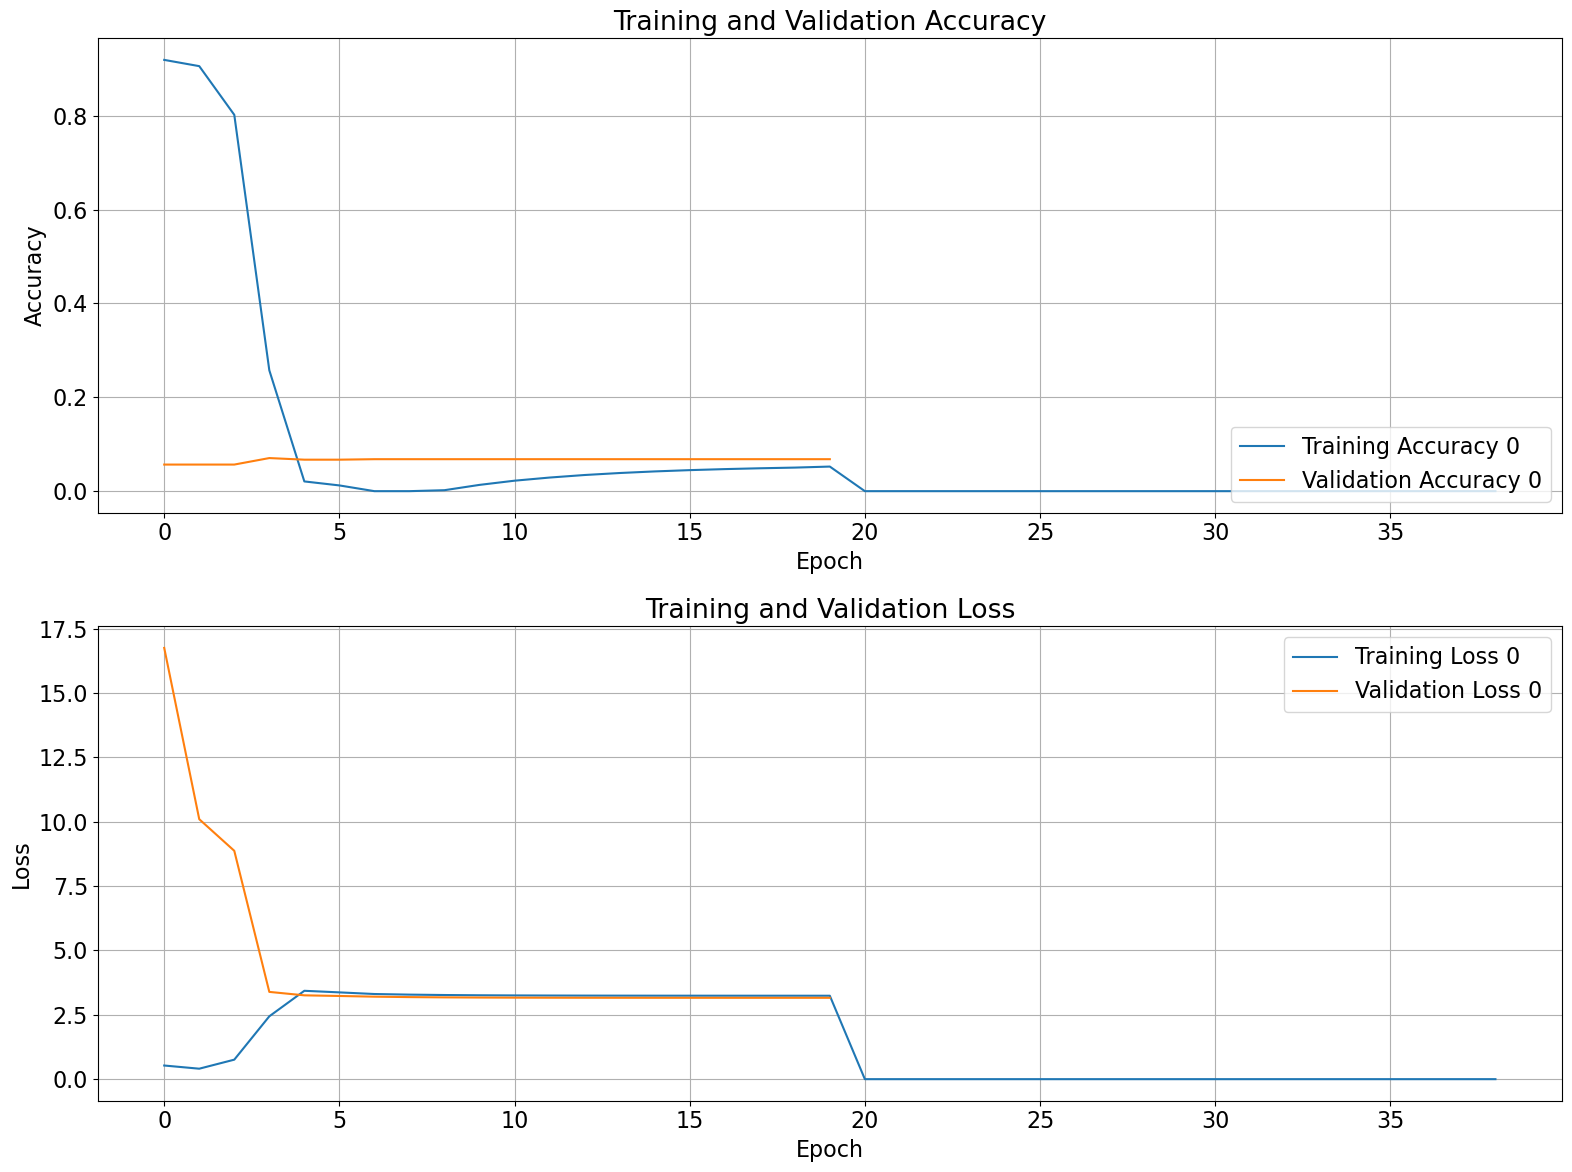

In [14]:
# Optional, plot the accuracy and loss curves of the training and validation sets.
def plot_training():
    
    epochs_range = range(40)
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 1, 1)
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid()
    for i in range(0,2,1):
        try:
            with open('models/training_history_{}.p'.format(i), 'rb') as fp:
                print('models/training_history_{}.p'.format(i))
                m = pickle.load(fp)[0]
                print('Training Accuracy {} try?'.format(i))
                acc = m['accuracy'] + ([0] * (epochs_range[-1] - len(m['accuracy'])))
                val_acc = m['val_accuracy'] + ([float('nan')] * (epochs_range[-1] - len(m['val_accuracy'])))
                
                print('Training Accuracy {}'.format(i))
                plt.plot(epochs_range[:-1], acc, label='Training Accuracy {}'.format(i))
                plt.plot(epochs_range[:-1], val_acc, label='Validation Accuracy {}'.format(i))
    
        except Exception as e:
            pass
        
    plt.legend(loc='lower right')

        
    plt.subplot(2, 1, 2)
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    for i in range(0,2,1):
        try:
            with open('models/training_history_{}.p'.format(i), 'rb') as fp:
                m = pickle.load(fp)[0]
                loss = m['loss'] + ([0] * (epochs_range[-1] - len(m['loss'])))
                val_loss = m['val_loss']
                val_loss += ([float('nan')] * (epochs_range[-1] - len(m['val_loss'])))
                
                plt.plot(epochs_range[:-1], loss, label='Training Loss {}'.format(i))
                plt.plot(epochs_range[:-1], val_loss, label='Validation Loss {}'.format(i))
    
        except Exception as e:
            pass
    
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    
plot_training()
